In [2]:
!wget -P /kaggle/input/titanic "https://github.com/relaxbear81/KaggleTitanicPrediction/raw/master/train.csv"
!wget -P /kaggle/input/titanic "https://github.com/relaxbear81/KaggleTitanicPrediction/raw/master/test.csv"

--2023-08-10 12:53:54--  https://github.com/relaxbear81/KaggleTitanicPrediction/raw/master/train.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/relaxbear81/KaggleTitanicPrediction/master/train.csv [following]
--2023-08-10 12:53:54--  https://raw.githubusercontent.com/relaxbear81/KaggleTitanicPrediction/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘/kaggle/input/titanic/train.csv’

train.csv           100%[===================>]  59.76K  --.-KB/s    in 0.002s  

2023-08-10 12:53:54 (34.8 MB/s) - ‘/kaggle/input/titanic/train.csv’ saved [6

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [4]:
#GitHub での表示があまりに縦長になり過ぎていたので、便宜的にコメントアウト
#pd.set_option("display.max_rows", None)
#pd.set_option('display.max_columns', None)
#np.set_printoptions(threshold=np.inf)

In [5]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
print(train_data.index)
print(len(train_data))

RangeIndex(start=0, stop=891, step=1)
891


In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [10]:
test_data[test_data["Parch"] > 5]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
139,1031,3,"Goodwin, Mr. Charles Frederick",male,40.0,1,6,CA 2144,46.90,NaN,S
342,1234,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.55,NaN,S
365,1257,3,"Sage, Mrs. John (Annie Bullen)",female,NaN,1,9,CA. 2343,69.55,NaN,S


train.csv での Parch の最大値は 6 、test.csv での Parch の最大値は 9 だが、正規化しやすいように 9 は外れ値と見なして 6 に置き換える。<br>
The maximum value of Parch in train.csv is 6, and the maximum value of Parch in test.csv is 9. To facilitate normalization, 9 is considered an outlier and replaced with 6.

In [11]:
train_data.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
train_data.shape

(891, 12)

In [13]:
train_data.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [14]:
train_data.isnull().any(axis=1)

0       True
1      False
2       True
3      False
4       True
       ...  
886     True
887    False
888     True
889    False
890     True
Length: 891, dtype: bool

In [15]:
train_data.isnull().any(axis=1).sum()

708

In [16]:
train_data.loc[:, "Age"]

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [17]:
print(train_data.loc[:, "Age"].isnull().sum())
print(train_data.loc[:, "Cabin"].isnull().sum())
print(train_data.loc[:, "Embarked"].isnull().sum())

177
687
2


In [18]:
train_data[train_data.loc[:, "Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [19]:
train_data[train_data.loc[:, "Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [20]:
train_data["Age"].sort_values()

803    0.42
755    0.67
644    0.75
469    0.75
78     0.83
       ... 
859     NaN
863     NaN
868     NaN
878     NaN
888     NaN
Name: Age, Length: 891, dtype: float64

In [21]:
processed_train_data = train_data.loc[:, ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
print(processed_train_data.dtypes)
processed_train_data = processed_train_data.replace({"male": 0, "female": 1})
processed_train_data = processed_train_data.replace({"C": 0, "Q": 1, "S": 2})
processed_train_data["Pclass"] -= 1
processed_train_data["Age"] = processed_train_data["Age"].mask(processed_train_data["Age"] < 1, 0)
print(processed_train_data.dtypes)
processed_train_data

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object
Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked    float64
dtype: object


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,2,0,22.0,1,0,7.2500,2.0
1,1,0,1,38.0,1,0,71.2833,0.0
2,1,2,1,26.0,0,0,7.9250,2.0
3,1,0,1,35.0,1,0,53.1000,2.0
4,0,2,0,35.0,0,0,8.0500,2.0
...,...,...,...,...,...,...,...,...
886,0,1,0,27.0,0,0,13.0000,2.0
887,1,0,1,19.0,0,0,30.0000,2.0
888,0,2,1,NaN,1,2,23.4500,2.0
889,1,0,0,26.0,0,0,30.0000,0.0


In [22]:
processed_test_data = test_data.loc[:, ["PassengerId", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
print(processed_test_data.dtypes)
processed_test_data = processed_test_data.replace({"male": 0, "female": 1})
processed_test_data = processed_test_data.replace({"C": 0, "Q": 1, "S": 2})
processed_test_data ["Pclass"] -= 1
processed_test_data["Age"] = processed_test_data["Age"].mask(processed_test_data["Age"] < 1, 0)
print(processed_test_data.dtypes)
processed_test_data

PassengerId      int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object
PassengerId      int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
dtype: object


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,2,0,34.5,0,0,7.8292,1
1,893,2,1,47.0,1,0,7.0000,2
2,894,1,0,62.0,0,0,9.6875,1
3,895,2,0,27.0,0,0,8.6625,2
4,896,2,1,22.0,1,1,12.2875,2
...,...,...,...,...,...,...,...,...
413,1305,2,0,NaN,0,0,8.0500,2
414,1306,0,1,39.0,0,0,108.9000,0
415,1307,2,0,38.5,0,0,7.2500,2
416,1308,2,0,NaN,0,0,8.0500,2


In [23]:
processed_train_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,0.383838,1.308642,0.352413,29.691877,0.523008,0.381594,32.204208,1.535433
std,0.486592,0.836071,0.477990,14.541121,1.102743,0.806057,49.693429,0.792088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,1.000000,2.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,2.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


In [24]:
processed_test_data.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,1.265550,0.363636,30.263554,0.447368,0.392344,35.627188,1.401914
std,120.810458,0.841838,0.481622,14.200303,0.896760,0.981429,55.907576,0.854496
min,892.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,0.000000,21.000000,0.000000,0.000000,7.895800,1.000000
50%,1100.500000,2.000000,0.000000,27.000000,0.000000,0.000000,14.454200,2.000000
75%,1204.750000,2.000000,1.000000,39.000000,1.000000,0.000000,31.500000,2.000000
max,1309.000000,2.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000


In [25]:
processed_train_data.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [26]:
print(processed_test_data.isnull().any())
processed_test_data[processed_test_data["Fare"].isnull()]

PassengerId    False
Pclass         False
Sex            False
Age             True
SibSp          False
Parch          False
Fare            True
Embarked       False
dtype: bool


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,2,0,60.5,0,0,NaN,2


In [27]:
processed_test_data["Parch"][processed_test_data["Parch"] == 9]

342    9
365    9
Name: Parch, dtype: int64

In [28]:
# The value 9 for "Parch" shall be considered an outlier and replaced with 6.
processed_test_data.loc[342, "Parch"] = 6
processed_test_data.loc[365, "Parch"] = 6
processed_test_data.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,1.265550,0.363636,30.263554,0.447368,0.377990,35.627188,1.401914
std,120.810458,0.841838,0.481622,14.200303,0.896760,0.870896,55.907576,0.854496
min,892.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,0.000000,21.000000,0.000000,0.000000,7.895800,1.000000
50%,1100.500000,2.000000,0.000000,27.000000,0.000000,0.000000,14.454200,2.000000
75%,1204.750000,2.000000,1.000000,39.000000,1.000000,0.000000,31.500000,2.000000
max,1309.000000,2.000000,1.000000,76.000000,8.000000,6.000000,512.329200,2.000000


後で、SibSp, Fare, Parch は正規化する。<br>
Later, normalize the features SibSp, Fare and Parch.

In [29]:
train_data[train_data["Fare"] == 0.0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [30]:
test_data[test_data["Fare"] == 0.0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
266,1158,1,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0,0,112051,0.0,NaN,S
372,1264,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0,B52 B54 B56,S


運賃 0？　この不思議な乗客たちはどうすべきか。<br>
Fare 0?  What to do with this strange passengers.

array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: >]], dtype=object)

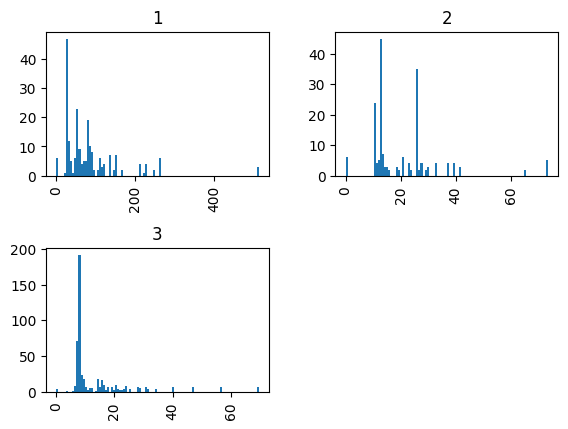

In [ ]:
train_data["Fare"].hist(by=train_data["Pclass"], bins=100)

array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: >]], dtype=object)

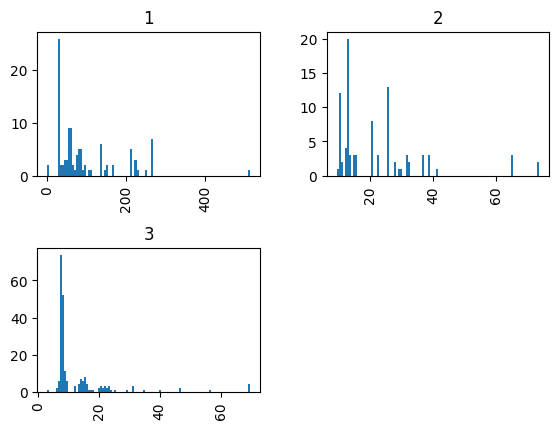

In [ ]:
test_data["Fare"].hist(by=test_data["Pclass"], bins=100)

In [ ]:
print(processed_train_data.groupby("Pclass")["Fare"].apply(lambda x: x.mode()))
#print(processed_train_data.groupby("Pclass")["Fare"].mode()) # Why don't work?
processed_train_data.groupby("Pclass")["Fare"].describe()

Pclass   
0       0    26.55
1       0    13.00
2       0     8.05
Name: Fare, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
0,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
1,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
2,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


In [ ]:
print(processed_test_data.groupby("Pclass")["Fare"].apply(lambda x: x.mode()))
processed_test_data.groupby("Pclass")["Fare"].describe()

Pclass   
0       0    26.55
1       0    13.00
2       0     7.75
Name: Fare, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
0,107.0,94.280297,84.435858,0.0000,30.10,60.0000,134.5,512.3292
1,93.0,22.202104,13.991877,9.6875,13.00,15.7500,26.0,73.5000
2,217.0,12.459678,10.803698,3.1708,7.75,7.8958,14.4,69.5500


In [ ]:
len(train_data[train_data["Fare"] == 0.0])

15

運賃 0 は集計のミスではないかと疑い、補正することを考えたが、15人中14人が死亡しているのは顕著な特徴と言える。検討の結果、運賃 0 は集計のミスによるものではなく、何か特殊な乗客を示す属性と考えられるので、このまま採用する。<br>

I suspected that the fare 0 might be an error in tabulation and considered correcting for it, but 14 of the 15 deaths is a remarkable features.  After review, I believe that fare 0 is not due to an error in tabulation, but is an attribute that indicates some special passenger, so we will adopt it as it is.

In [ ]:
processed_train_data.corr(method="pearson")

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,0.543351,-0.077746,-0.035322,0.081629,0.257307,-0.169718
Pclass,-0.338481,1.000000,-0.131900,-0.368829,0.083081,0.018443,-0.549500,0.164681
Sex,0.543351,-0.131900,1.000000,-0.093082,0.114631,0.245489,0.182333,-0.110320
Age,-0.077746,-0.368829,-0.093082,1.000000,-0.308224,-0.189459,0.095894,-0.032314
SibSp,-0.035322,0.083081,0.114631,-0.308224,1.000000,0.414838,0.159651,0.068900
Parch,0.081629,0.018443,0.245489,-0.189459,0.414838,1.000000,0.216225,0.040449
Fare,0.257307,-0.549500,0.182333,0.095894,0.159651,0.216225,1.000000,-0.226311
Embarked,-0.169718,0.164681,-0.110320,-0.032314,0.068900,0.040449,-0.226311,1.000000


In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams

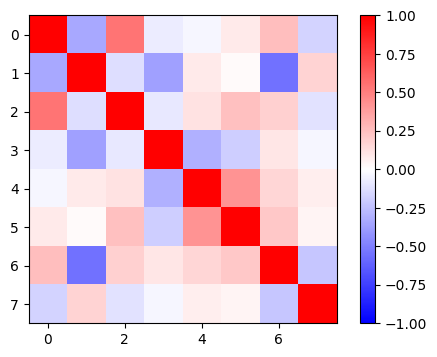

In [ ]:
rcParams["figure.figsize"] = 6, 4
heatmap = plt.imshow(processed_train_data.corr(method="pearson"), cmap="bwr", vmax=1, vmin=-1)
plt.colorbar(heatmap)
# Survived Pclass Sex Age SibSp Parch Fare Embarked

In [ ]:
processed_train_data_dropna = processed_train_data.dropna(subset=["Age"])
print(len(processed_train_data_dropna))
processed_train_data_dropna.isnull().any()

714


Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

"Age" には NA値が多いため、"Age" に NA値を持つ行を削除して相関に変化があるかを検証。結果、ほとんど変化なし。<br>
"Age" has many NA values, so we removed rows with NA values in "Age" and verified if the correlation changed. The result was almost no change.

In [ ]:
processed_train_data_dropna.corr(method="pearson")

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.359653,0.538826,-0.077746,-0.017358,0.093317,0.268189,-0.181979
Pclass,-0.359653,1.000000,-0.155460,-0.368829,0.067247,0.025683,-0.554182,0.244145
Sex,0.538826,-0.155460,1.000000,-0.093082,0.103950,0.246972,0.184994,-0.109639
Age,-0.077746,-0.368829,-0.093082,1.000000,-0.308224,-0.189459,0.095894,-0.032314
SibSp,-0.017358,0.067247,0.103950,-0.308224,1.000000,0.383820,0.138329,0.033064
Parch,0.093317,0.025683,0.246972,-0.189459,0.383820,1.000000,0.205119,0.011803
Fare,0.268189,-0.554182,0.184994,0.095894,0.138329,0.205119,1.000000,-0.283510
Embarked,-0.181979,0.244145,-0.109639,-0.032314,0.033064,0.011803,-0.283510,1.000000


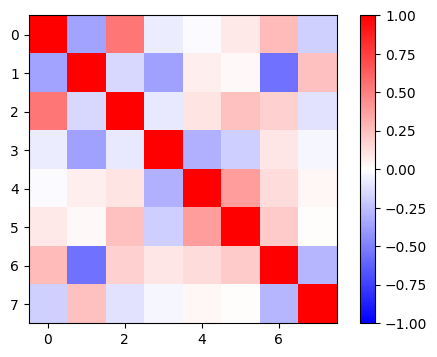

In [ ]:
heatmap2 = plt.imshow(processed_train_data_dropna.corr(method="pearson"), cmap="bwr", vmax=1, vmin=-1)
plt.colorbar(heatmap2)

Replace the age of children under 1 year old with 0.

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Sex'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Embarked'}>, <Axes: >]], dtype=object)

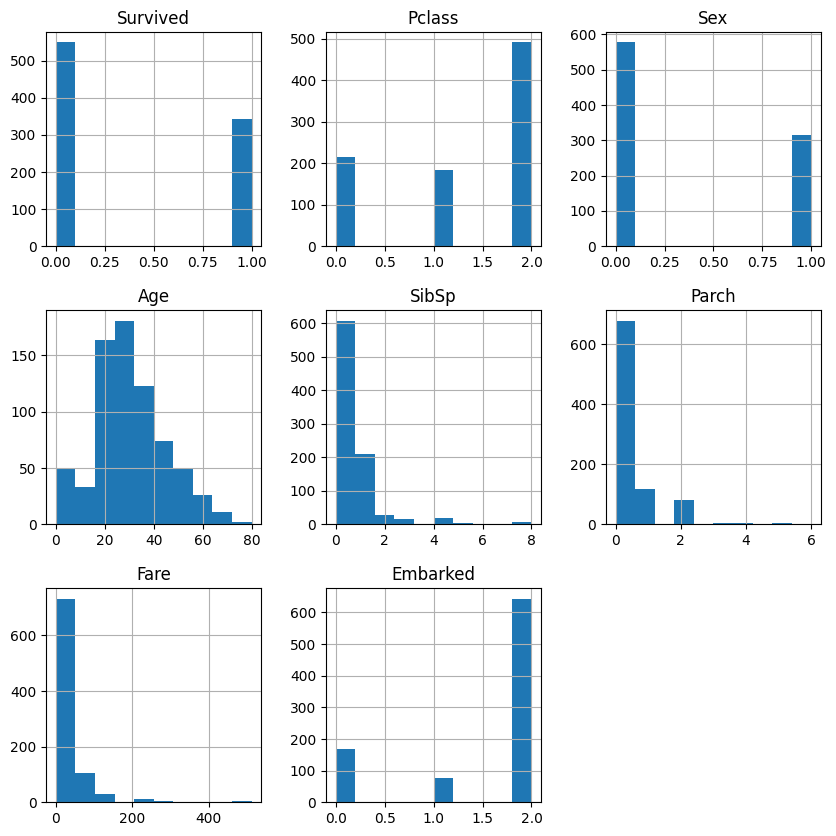

In [ ]:
rcParams["figure.figsize"] = 10, 10
processed_train_data.hist()

<Axes: >

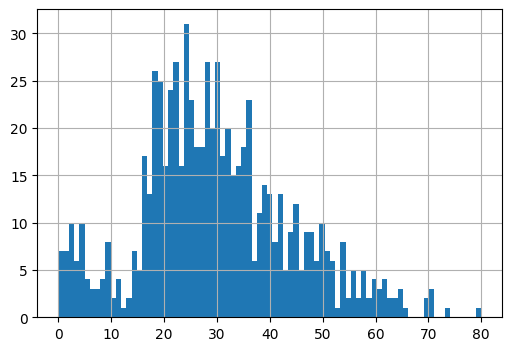

In [ ]:
rcParams["figure.figsize"] = 6, 4
processed_train_data["Age"].hist(bins=81)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

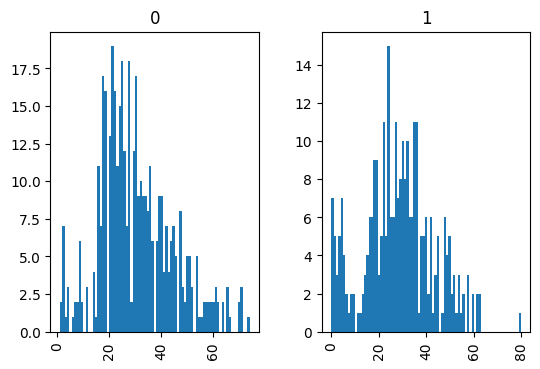

In [ ]:
processed_train_data["Age"].hist(by=processed_train_data["Survived"], bins=81)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

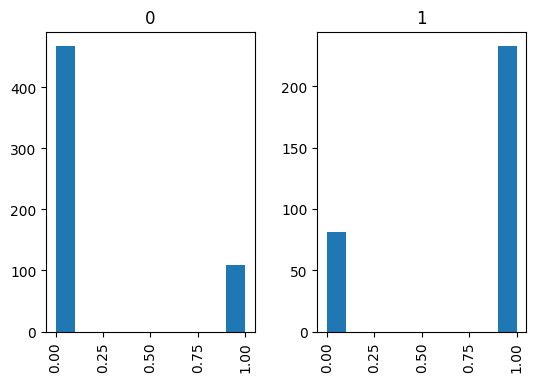

In [ ]:
processed_train_data["Survived"].hist(by=processed_train_data["Sex"])

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

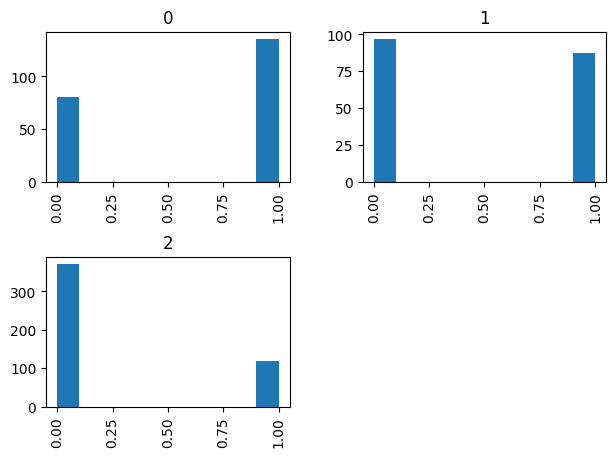

In [ ]:
rcParams["figure.figsize"] = 7, 5
processed_train_data["Survived"].hist(by=processed_train_data["Pclass"])

array([[<Axes: title={'center': '0.0'}>, <Axes: title={'center': '1.0'}>],
       [<Axes: title={'center': '2.0'}>, <Axes: >]], dtype=object)

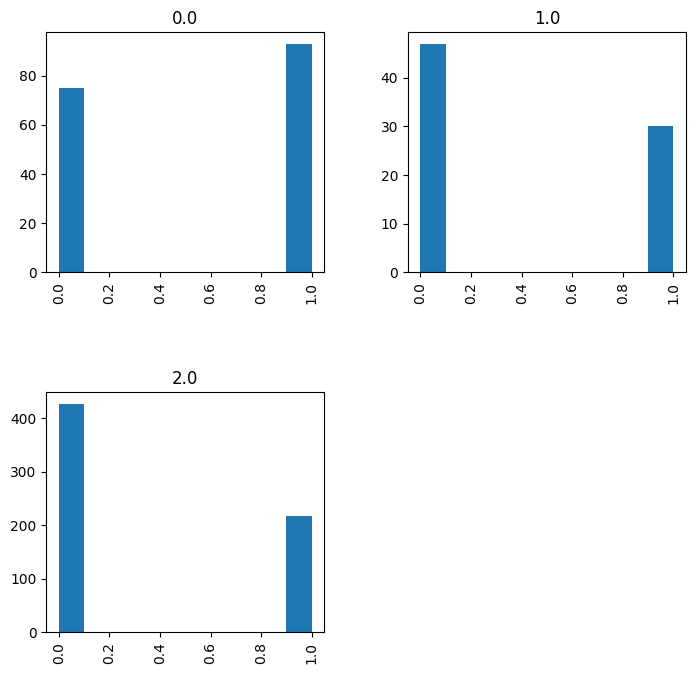

In [ ]:
rcParams["figure.figsize"] = 8, 8
processed_train_data["Survived"].hist(by=processed_train_data["Embarked"])

array([[<Axes: title={'center': '0.0'}>, <Axes: title={'center': '1.0'}>],
       [<Axes: title={'center': '2.0'}>, <Axes: >]], dtype=object)

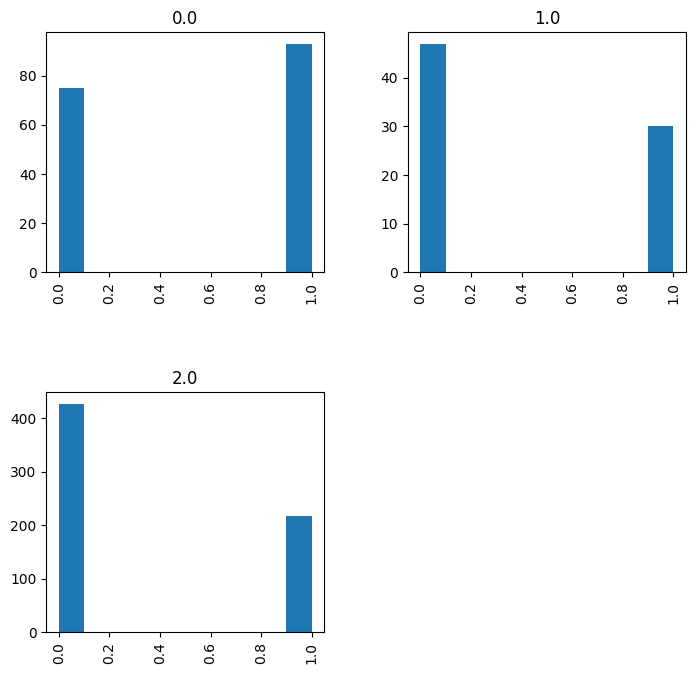

In [ ]:
rcParams["figure.figsize"] = 8, 8
processed_train_data["Survived"].hist(by=processed_train_data["Embarked"])

array([[<Axes: title={'center': '0.0'}>, <Axes: title={'center': '1.0'}>],
       [<Axes: title={'center': '2.0'}>, <Axes: >]], dtype=object)

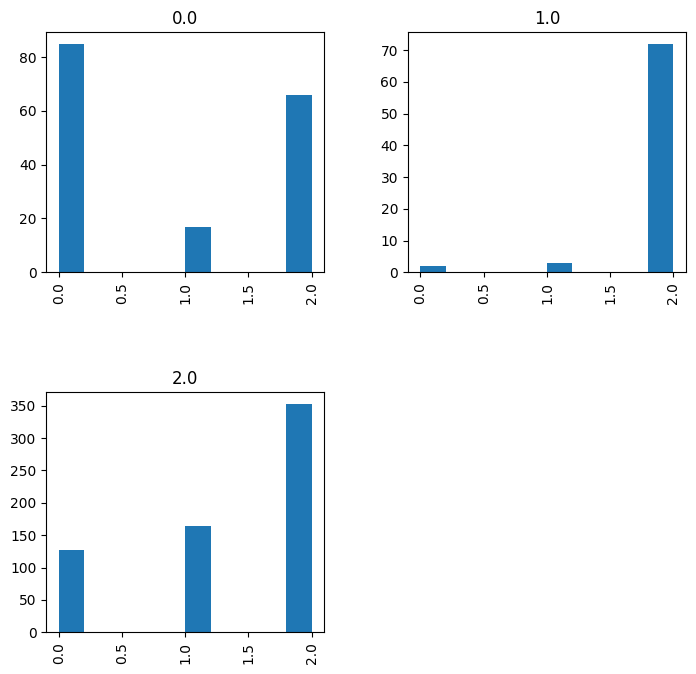

In [ ]:
processed_train_data["Pclass"].hist(by=processed_train_data["Embarked"])

シェルブールから乗船する乗客だけ生存率が高いのは、おそらくシェルブールからの乗客の多くが上流階級だからだろう。<br>
The survival rate is high only for passengers embarking from Cherbourg, perhaps because many of the passengers from Cherbourg are upper class.

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>],
       [<Axes: title={'center': '8'}>, <Axes: >, <Axes: >]], dtype=object)

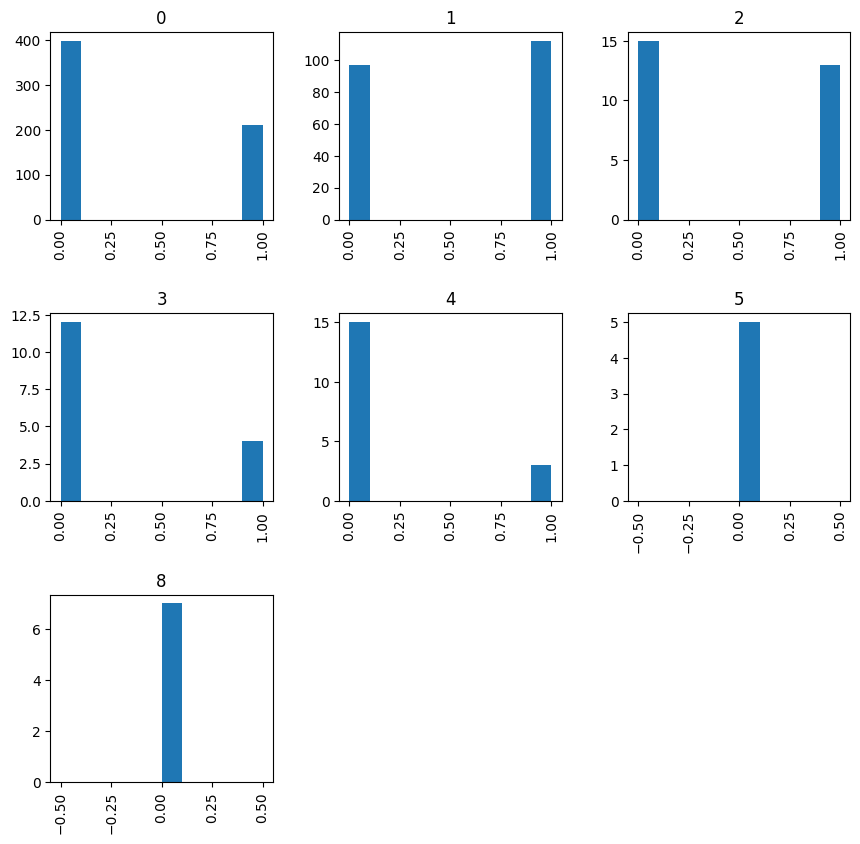

In [ ]:
rcParams["figure.figsize"] = 10, 10
processed_train_data["Survived"].hist(by=processed_train_data["SibSp"])

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>],
       [<Axes: title={'center': '6'}>, <Axes: >, <Axes: >]], dtype=object)

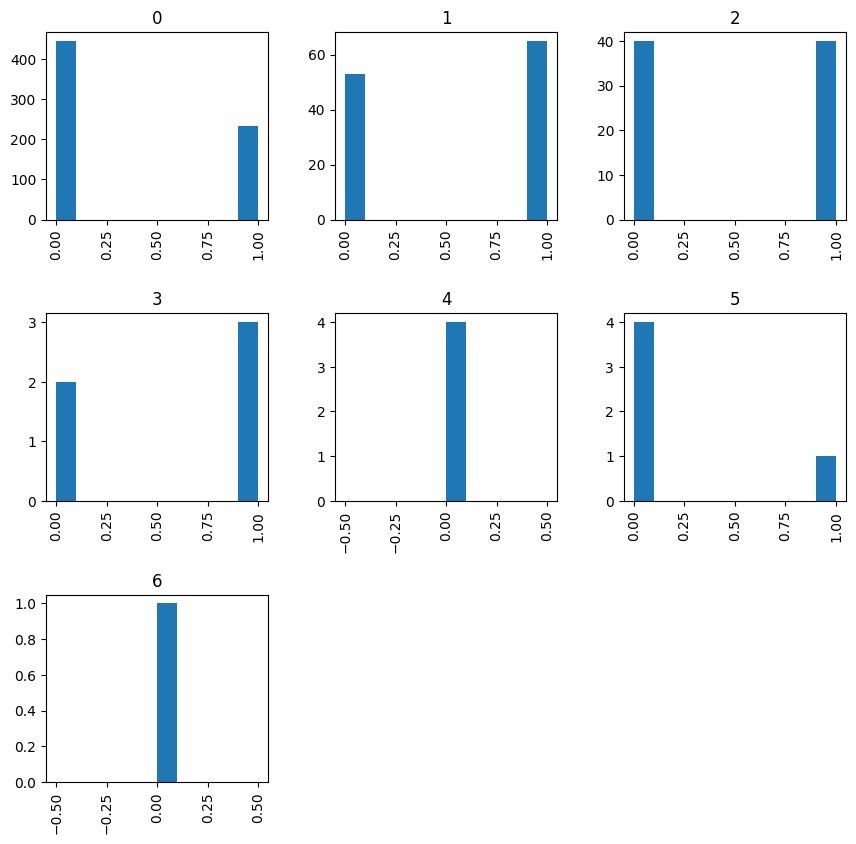

In [ ]:
processed_train_data["Survived"].hist(by=processed_train_data["Parch"])

array([[<Axes: title={'center': 'Fare'}>]], dtype=object)

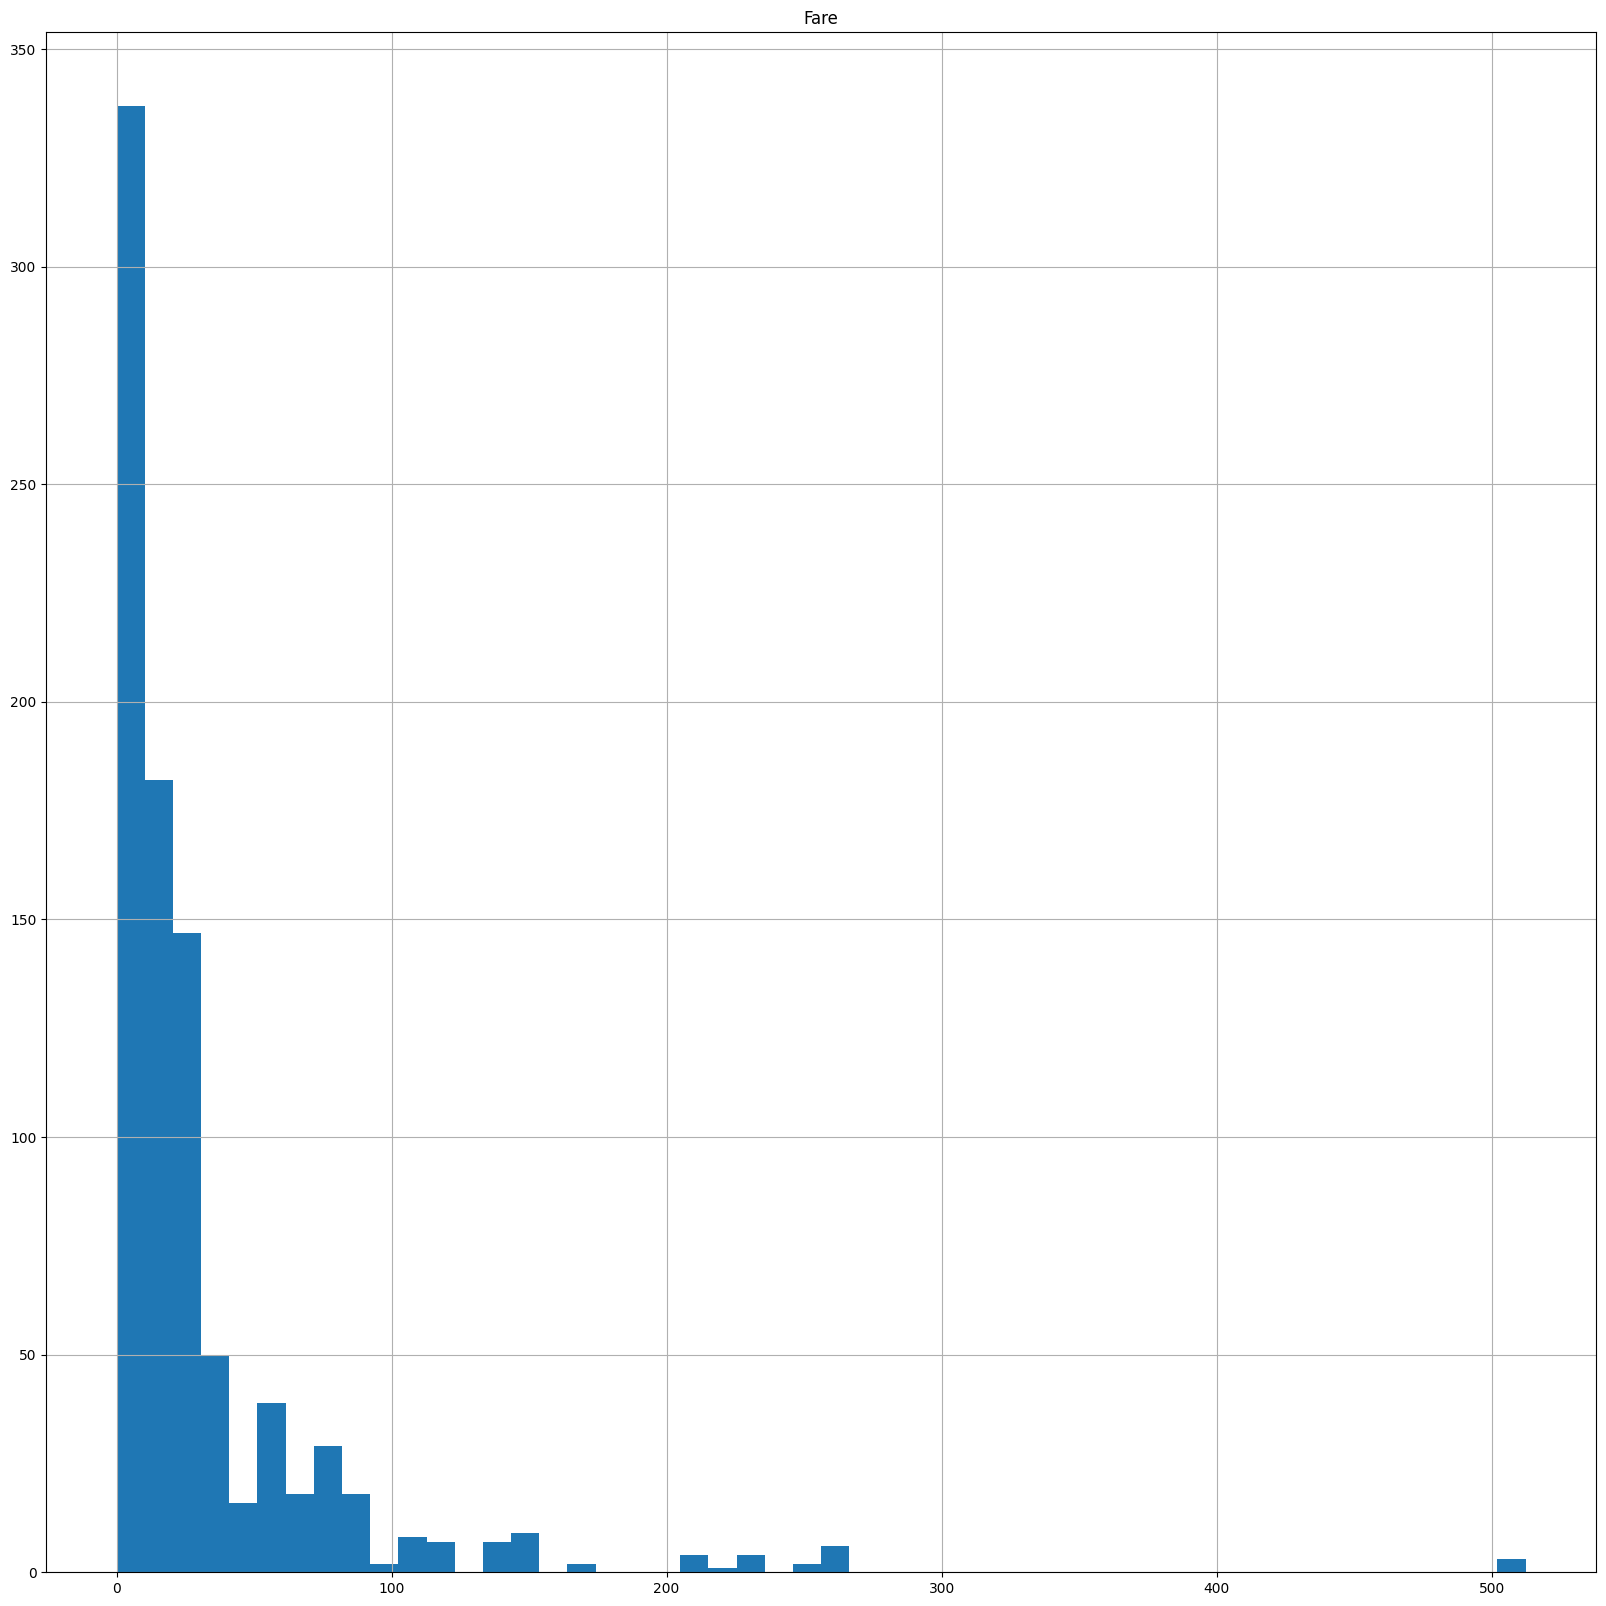

In [ ]:
rcParams["figure.figsize"] = 20, 20
processed_train_data.hist("Fare", bins=50)

In [ ]:
print(processed_train_data[processed_train_data["Fare"] > 300])

     Survived  Pclass  Sex   Age  SibSp  Parch      Fare  Embarked
258         1       0    1  35.0      0      0  512.3292       0.0
679         1       0    0  36.0      0      1  512.3292       0.0
737         1       0    0  35.0      0      0  512.3292       0.0


彼らは特別な富裕層。<br>
They are a special wealthy group.

In [ ]:
print(processed_train_data[processed_train_data["Fare"] > 200].sort_values("Fare"))

     Survived  Pclass  Sex   Age  SibSp  Parch      Fare  Embarked
779         1       0    1  43.0      0      1  211.3375       2.0
730         1       0    1  29.0      0      0  211.3375       2.0
689         1       0    1  15.0      0      1  211.3375       2.0
377         0       0    0  27.0      0      2  211.5000       0.0
527         0       0    0   NaN      0      0  221.7792       2.0
716         1       0    1  38.0      0      0  227.5250       0.0
700         1       0    1  18.0      1      0  227.5250       0.0
380         1       0    1  42.0      0      0  227.5250       0.0
557         0       0    0   NaN      0      0  227.5250       0.0
118         0       0    0  24.0      0      1  247.5208       0.0
299         1       0    1  50.0      0      1  247.5208       0.0
311         1       0    1  18.0      2      2  262.3750       0.0
742         1       0    1  21.0      2      2  262.3750       0.0
27          0       0    0  19.0      3      2  263.0000      

金持ちは助かる率が高そうである。<br>
The rich seem to have a higher rate of survival.

In [ ]:
import torch

In [ ]:
processed_train_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,0.383838,1.308642,0.352413,29.691877,0.523008,0.381594,32.204208,1.535433
std,0.486592,0.836071,0.477990,14.541121,1.102743,0.806057,49.693429,0.792088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,1.000000,2.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,2.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


SibSp, Fare, Parch を正規化する。<br>
Normalize SibSp, Fare, and Parch.

In [ ]:
processed_train_data["SibSp"] = (processed_train_data["SibSp"] - processed_train_data["SibSp"].min()) / (processed_train_data["SibSp"].max() - processed_train_data["SibSp"].min())
processed_train_data["Fare"] = (processed_train_data["Fare"] - processed_train_data["Fare"].min()) / (processed_train_data["Fare"].max() - processed_train_data["Fare"].min())
processed_train_data["Parch"] = (processed_train_data["Parch"] - processed_train_data["Parch"].min()) / (processed_train_data["Parch"].max() - processed_train_data["Parch"].min())
print("done")

done


In [ ]:
processed_test_data["SibSp"] = (processed_test_data["SibSp"] - processed_test_data["SibSp"].min()) / (processed_test_data["SibSp"].max() - processed_test_data["SibSp"].min())
processed_test_data["Fare"] = (processed_test_data["Fare"] - processed_test_data["Fare"].min()) / (processed_test_data["Fare"].max() - processed_test_data["Fare"].min())
processed_test_data["Parch"] = (processed_test_data["Parch"] - processed_test_data["Parch"].min()) / (processed_test_data["Parch"].max() - processed_test_data["Parch"].min())
print("done")

done


In [ ]:
processed_train_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,0.383838,1.308642,0.352413,29.691877,0.065376,0.063599,0.062858,1.535433
std,0.486592,0.836071,0.477990,14.541121,0.137843,0.134343,0.096995,0.792088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,0.015440,1.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000,0.028213,2.000000
75%,1.000000,2.000000,1.000000,38.000000,0.125000,0.000000,0.060508,2.000000
max,1.000000,2.000000,1.000000,80.000000,1.000000,1.000000,1.000000,2.000000


In [ ]:
processed_test_data.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,1.265550,0.363636,30.263554,0.055921,0.062998,0.069540,1.401914
std,120.810458,0.841838,0.481622,14.200303,0.112095,0.145149,0.109124,0.854496
min,892.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,0.000000,21.000000,0.000000,0.000000,0.015412,1.000000
50%,1100.500000,2.000000,0.000000,27.000000,0.000000,0.000000,0.028213,2.000000
75%,1204.750000,2.000000,1.000000,39.000000,0.125000,0.000000,0.061484,2.000000
max,1309.000000,2.000000,1.000000,76.000000,1.000000,1.000000,1.000000,2.000000


array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Sex'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Embarked'}>, <Axes: >]], dtype=object)

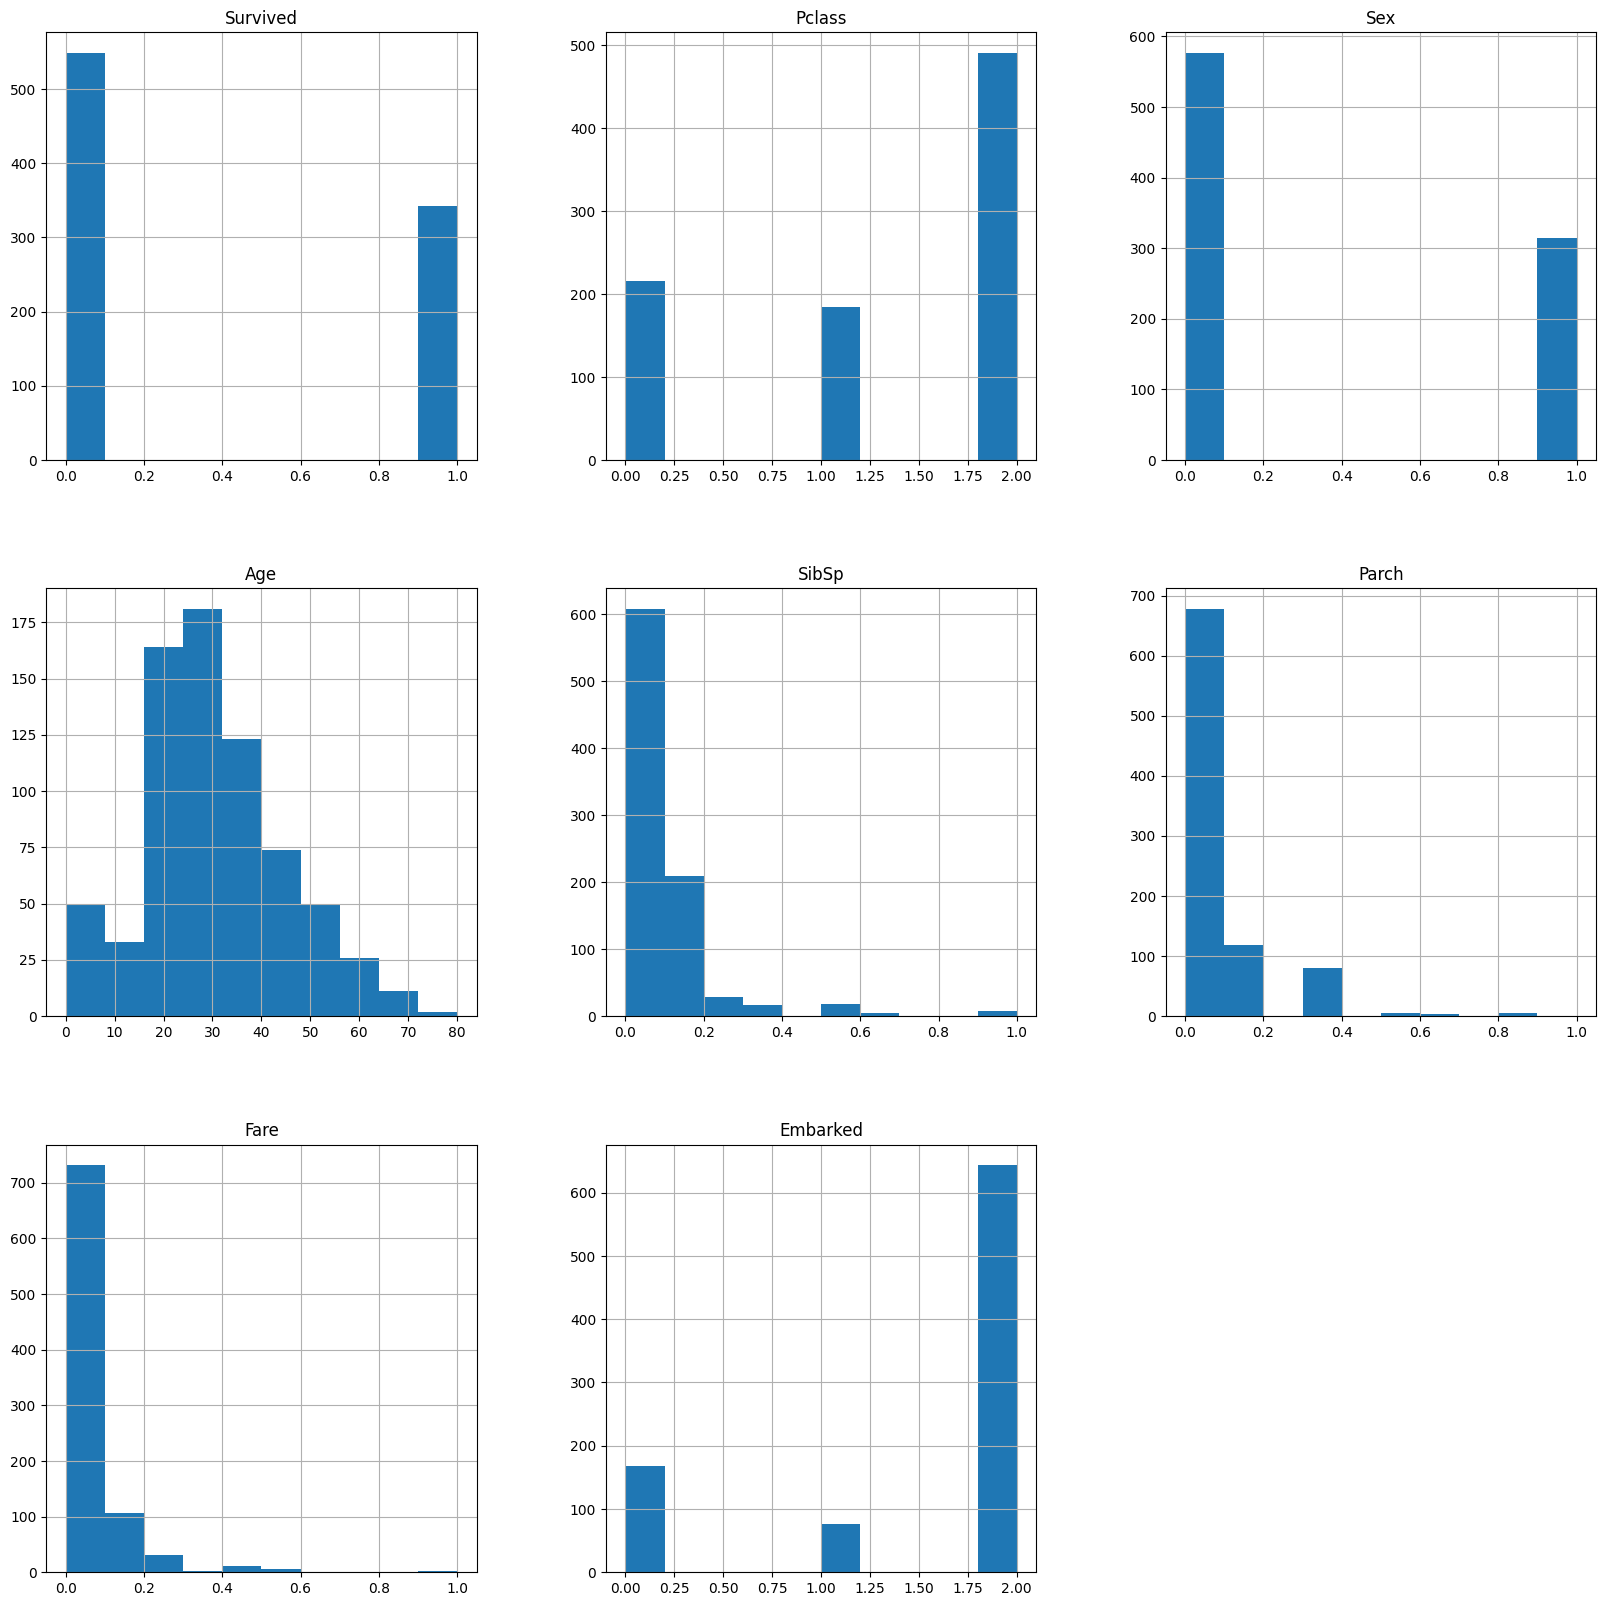

In [ ]:
processed_train_data.hist()

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Sex'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Embarked'}>, <Axes: >]], dtype=object)

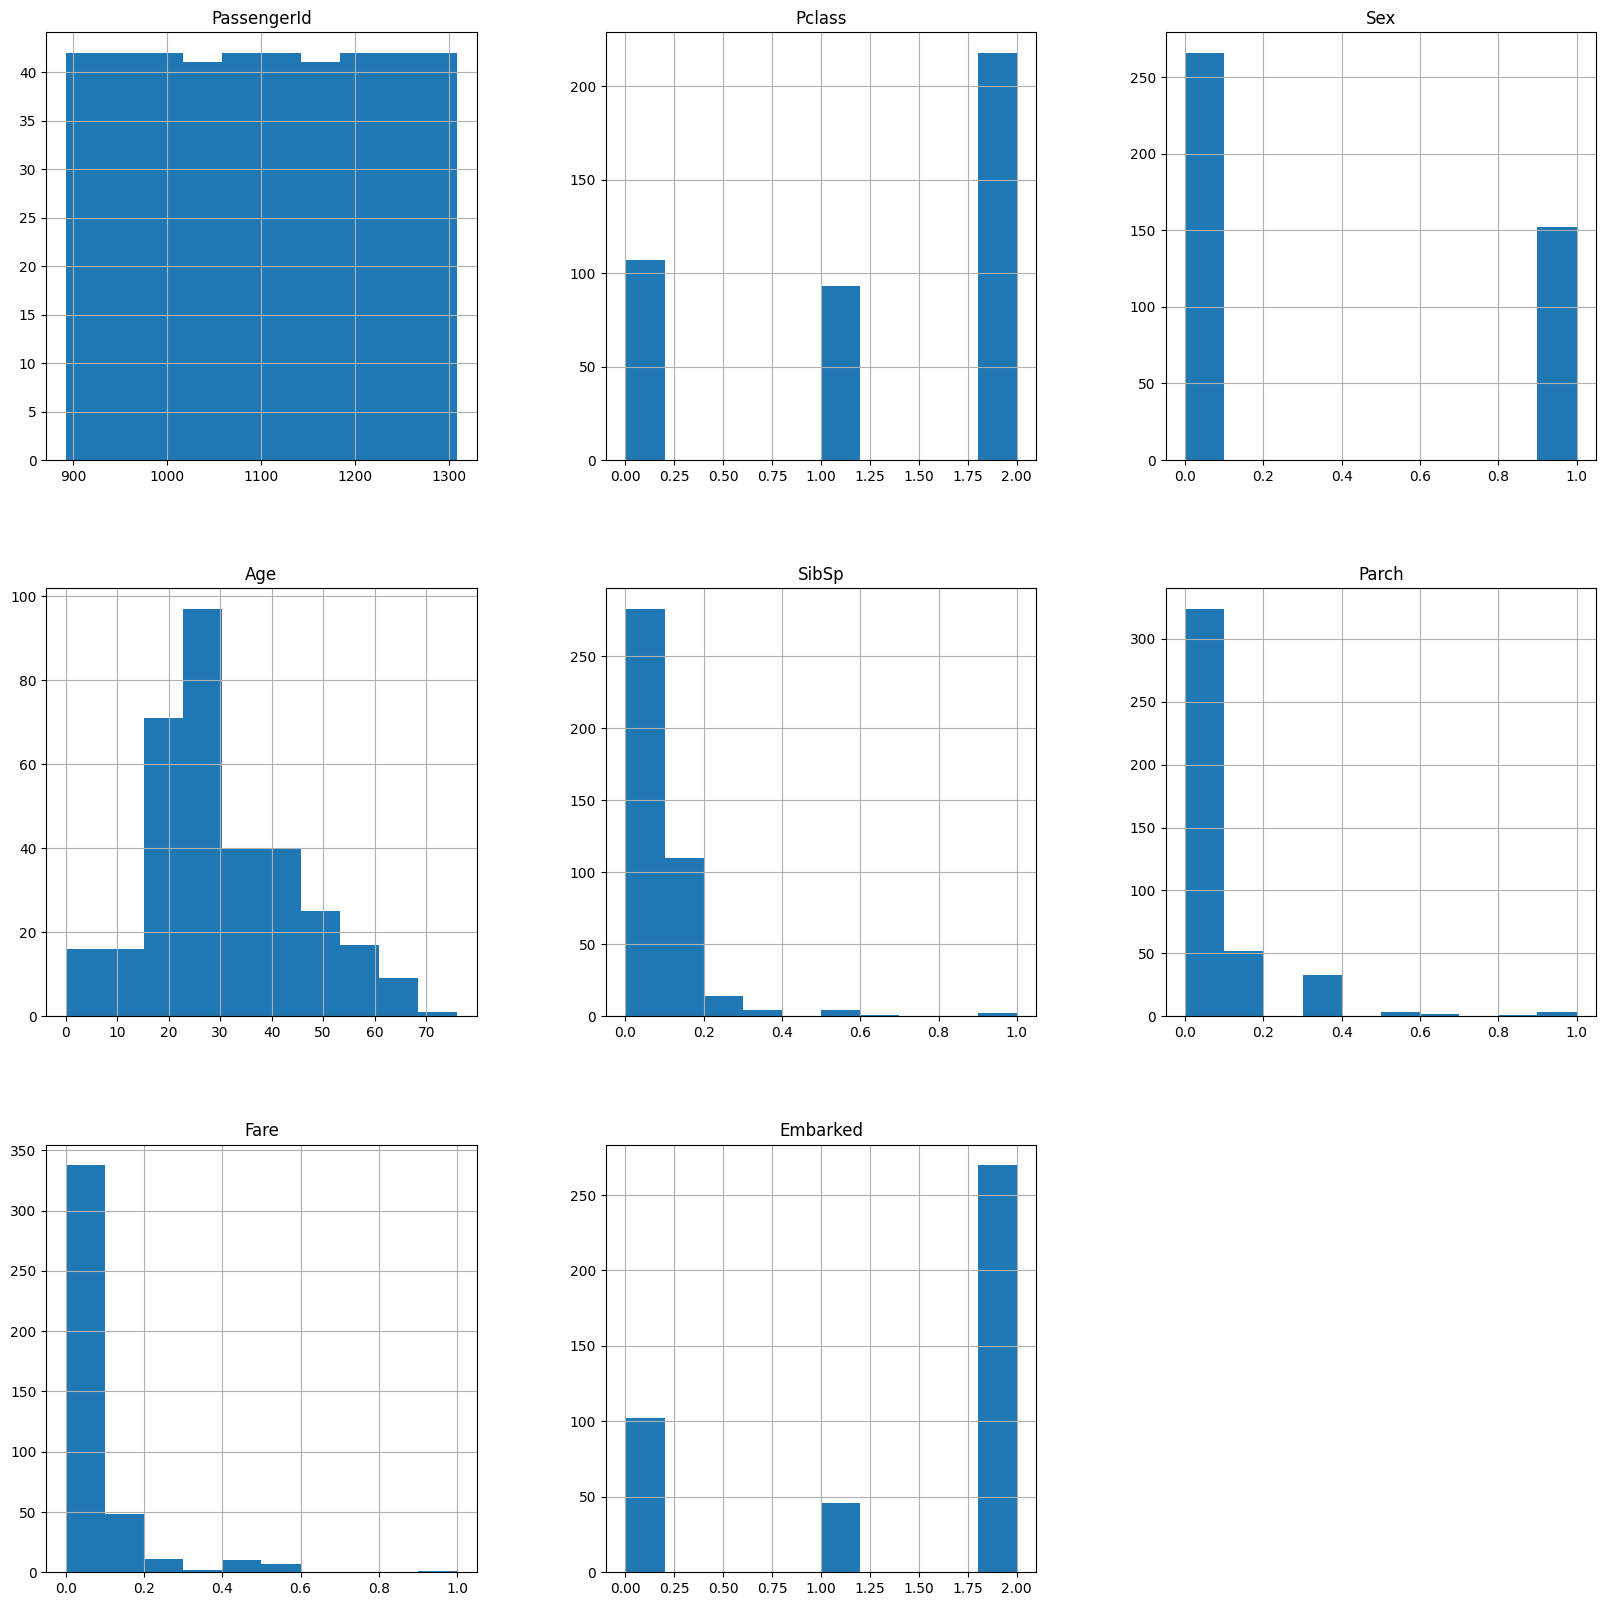

In [ ]:
processed_test_data.hist()

In [ ]:
def one_hot_encode(data, size):
    n = int(size)
    I = np.eye(n)
    ret_list = []

    for datum in data:
        if np.isnan(datum):
            ret_list.append(np.zeros(n))
        else:
            ret_list.append(I[int(datum)])

    ret_list = np.array(ret_list)
    return torch.tensor(ret_list, dtype=torch.float)

In [ ]:
pcls = one_hot_encode(processed_train_data["Pclass"], processed_train_data["Pclass"].max() + 1)
age = one_hot_encode(processed_train_data["Age"], processed_train_data["Age"].max() + 1)
emb = one_hot_encode(processed_train_data["Embarked"], processed_train_data["Embarked"].max() + 1)
print(pcls.shape, age.shape, emb.shape)

torch.Size([891, 3]) torch.Size([891, 81]) torch.Size([891, 3])


In [ ]:
# The size should match that of train_data.
test_pcls = one_hot_encode(processed_test_data["Pclass"], processed_train_data["Pclass"].max() + 1)
test_age = one_hot_encode(processed_test_data["Age"], processed_train_data["Age"].max() + 1)
test_emb = one_hot_encode(processed_test_data["Embarked"], processed_train_data["Embarked"].max() + 1)
print(test_pcls.shape, test_age.shape, test_emb.shape)

torch.Size([418, 3]) torch.Size([418, 81]) torch.Size([418, 3])


In [ ]:
label = torch.tensor(processed_train_data["Survived"], dtype=torch.float).unsqueeze(1)
sex = torch.tensor(processed_train_data["Sex"], dtype=torch.float).unsqueeze(1)
sibsp = torch.tensor(processed_train_data["SibSp"], dtype=torch.float).unsqueeze(1)
parch = torch.tensor(processed_train_data["Parch"], dtype=torch.float).unsqueeze(1)
fare = torch.tensor(processed_train_data["Fare"], dtype=torch.float).unsqueeze(1)
print(label.shape, sex.shape, sibsp.shape, parch.shape, fare.shape)

torch.Size([891, 1]) torch.Size([891, 1]) torch.Size([891, 1]) torch.Size([891, 1]) torch.Size([891, 1])


In [ ]:
test_pid = torch.tensor(processed_test_data["PassengerId"], dtype=torch.float).unsqueeze(1)
test_sex = torch.tensor(processed_test_data["Sex"], dtype=torch.float).unsqueeze(1)
test_sibsp = torch.tensor(processed_test_data["SibSp"], dtype=torch.float).unsqueeze(1)
test_parch = torch.tensor(processed_test_data["Parch"], dtype=torch.float).unsqueeze(1)
test_fare = torch.tensor(processed_test_data["Fare"], dtype=torch.float).unsqueeze(1)
print(test_pid.shape, test_sex.shape, test_sibsp.shape, test_parch.shape, test_fare.shape)

torch.Size([418, 1]) torch.Size([418, 1]) torch.Size([418, 1]) torch.Size([418, 1]) torch.Size([418, 1])


In [ ]:
train_X =  torch.cat([label, pcls, sex, age, sibsp, parch, fare, emb], dim=1)
train_X.shape

torch.Size([891, 92])

In [ ]:
test_X = torch.cat([test_pid, test_pcls, test_sex, test_age, test_sibsp, test_parch, test_fare, test_emb], dim=1)
test_X.shape

torch.Size([418, 92])

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_size = int(train_X.shape[0] * 0.85)
val_size = train_X.shape[0] - train_size
print(train_size, val_size)

757 134


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class TitanicNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(91, 91)
        self.norm1 = nn.BatchNorm1d(91)
        self.drop1 = nn.Dropout(0.9)

        self.layer2 = nn.Linear(91, 91)
        self.norm2 = nn.BatchNorm1d(91)
        self.drop2 = nn.Dropout(0.9)

        self.layer3 = nn.Linear(91, 40)
        self.norm3 = nn.BatchNorm1d(40)
        self.drop3 = nn.Dropout(0.9)

        self.layer4 = nn.Linear(40, 1)



    def forward(self, x):
        skip = x

        x = self.layer1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.drop1(x)

        x = self.layer2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.drop2(x)

        x = self.layer3(x + skip)
        x = self.norm3(x)
        x = self.drop3(x)

        x = self.layer4(x)

        return x

In [ ]:
!pip install torchinfo

In [ ]:
train_set, val_set = torch.utils.data.random_split(train_X, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_set, batch_size=757, shuffle=True)
val_loader = DataLoader(val_set, batch_size=134)

model = TitanicNet()

learning_rate = 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
TitanicNet                               --
├─Linear: 1-1                            8,372
├─BatchNorm1d: 1-2                       182
├─Dropout: 1-3                           --
├─Linear: 1-4                            8,372
├─BatchNorm1d: 1-5                       182
├─Dropout: 1-6                           --
├─Linear: 1-7                            3,680
├─BatchNorm1d: 1-8                       80
├─Dropout: 1-9                           --
├─Linear: 1-10                           41
Total params: 20,909
Trainable params: 20,909
Non-trainable params: 0

In [ ]:
epochs = 3000

train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(epochs):

    for batch in train_loader:
        model.train()
        labels = batch[:, 0].unsqueeze(1)
        X = batch[:, 1:]

        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            temp_loss = loss.item()
            train_loss_hist.append(temp_loss)
            acc = (torch.round(F.sigmoid(pred)) == labels).sum() / len(labels)
            acc=acc.item()
            train_acc_hist.append(acc)

    with torch.no_grad():

        for val_batch in val_loader:
            model.eval()
            labels = val_batch[:, 0].unsqueeze(1)
            X = val_batch[:, 1:]
            pred = model(X)
            val_loss = criterion(pred, labels)

            val_temp_loss = val_loss.item()
            val_loss_hist.append(val_temp_loss)
            val_acc = (torch.round(F.sigmoid(pred)) == labels).sum() / len(labels)
            val_acc = val_acc.item()
            val_acc_hist.append(val_acc)

    if epoch % 100 == 0:
        print(f"epoch:{epoch}, train_loss={temp_loss}, validation_loss={val_temp_loss}")

epoch:0, train_loss=0.9625572562217712, validation_loss=0.6979060769081116
epoch:100, train_loss=0.7776165008544922, validation_loss=0.6328723430633545
epoch:200, train_loss=0.6736093163490295, validation_loss=0.6161283254623413
epoch:300, train_loss=0.6380356550216675, validation_loss=0.5933360457420349
epoch:400, train_loss=0.5950732827186584, validation_loss=0.5518668293952942
epoch:500, train_loss=0.5909399390220642, validation_loss=0.5126243829727173
epoch:600, train_loss=0.5406933426856995, validation_loss=0.4856663644313812
epoch:700, train_loss=0.5157923102378845, validation_loss=0.46979111433029175
epoch:800, train_loss=0.5090736746788025, validation_loss=0.45962244272232056
epoch:900, train_loss=0.48295608162879944, validation_loss=0.4562288820743561
epoch:1000, train_loss=0.47440066933631897, validation_loss=0.4590508043766022
epoch:1100, train_loss=0.478708416223526, validation_loss=0.462902694940567
epoch:1200, train_loss=0.4597721993923187, validation_loss=0.4742403626441

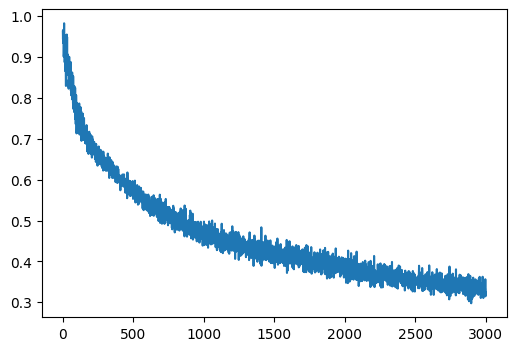

In [ ]:
rcParams["figure.figsize"] = 6, 4
plt.plot(train_loss_hist)

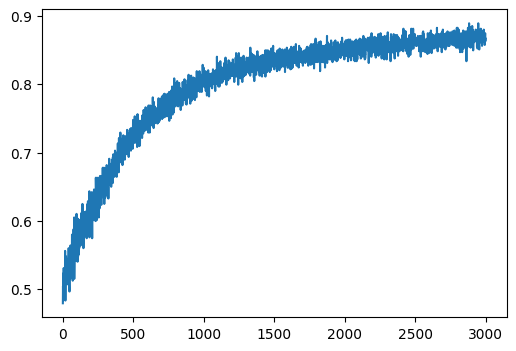

In [ ]:
plt.plot(train_acc_hist)

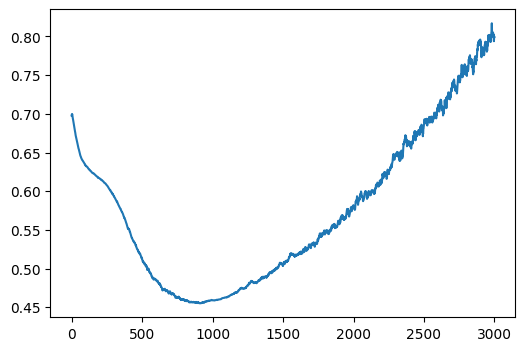

In [ ]:
plt.plot(val_loss_hist)

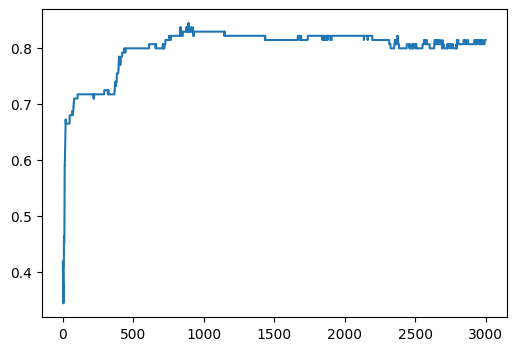

In [ ]:
plt.plot(val_acc_hist)

700エポックくらいで止めてみるか。<br>
I'd stop at about 700 epochs.

In [ ]:
train_set, val_set = torch.utils.data.random_split(train_X, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=757, shuffle=True)
val_loader = DataLoader(val_set, batch_size=134)

model = TitanicNet()

learning_rate = 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
TitanicNet                               --
├─Linear: 1-1                            8,372
├─BatchNorm1d: 1-2                       182
├─Dropout: 1-3                           --
├─Linear: 1-4                            8,372
├─BatchNorm1d: 1-5                       182
├─Dropout: 1-6                           --
├─Linear: 1-7                            3,680
├─BatchNorm1d: 1-8                       80
├─Dropout: 1-9                           --
├─Linear: 1-10                           41
Total params: 20,909
Trainable params: 20,909
Non-trainable params: 0

In [ ]:
from tqdm.notebook import tqdm
epochs = 650

train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []
pred_hist = []

for epoch in range(epochs):

    for batch in train_loader:
        model.train()
        labels = batch[:, 0].unsqueeze(1)
        #labels = torch.ones_like(labels)
        X = batch[:, 1:]

        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            temp_loss = loss.item()
            train_loss_hist.append(temp_loss)
            pred_hist.append(torch.round(F.sigmoid(pred)))
            acc = (torch.round(F.sigmoid(pred)) == labels).sum() / len(labels)
            acc=acc.item()
            train_acc_hist.append(acc)

    with torch.no_grad():

        for val_batch in val_loader:
            model.eval()
            labels = val_batch[:, 0].unsqueeze(1)
            X = val_batch[:, 1:]
            pred = model(X)
            val_loss = criterion(pred, labels)

            val_temp_loss = val_loss.item()
            val_loss_hist.append(val_temp_loss)
            val_acc = (torch.round(F.sigmoid(pred)) == labels).sum() / len(labels)
            val_acc = val_acc.item()
            val_acc_hist.append(val_acc)

    if epoch % 100 == 0:
        print(f"epoch:{epoch}, train_loss={temp_loss}, validation_loss={val_temp_loss}")

epoch:0, train_loss=0.970252513885498, validation_loss=0.6788877844810486
epoch:100, train_loss=0.8008132576942444, validation_loss=0.6314715147018433
epoch:200, train_loss=0.6812970638275146, validation_loss=0.6185303926467896
epoch:300, train_loss=0.6412156820297241, validation_loss=0.600230872631073
epoch:400, train_loss=0.6295090913772583, validation_loss=0.5616639256477356
epoch:500, train_loss=0.6122782230377197, validation_loss=0.515600323677063
epoch:600, train_loss=0.5363812446594238, validation_loss=0.47592806816101074


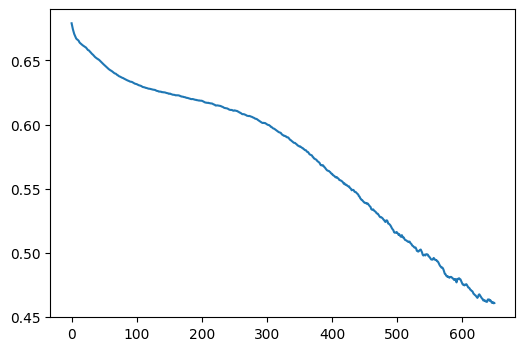

In [ ]:
plt.plot(val_loss_hist)

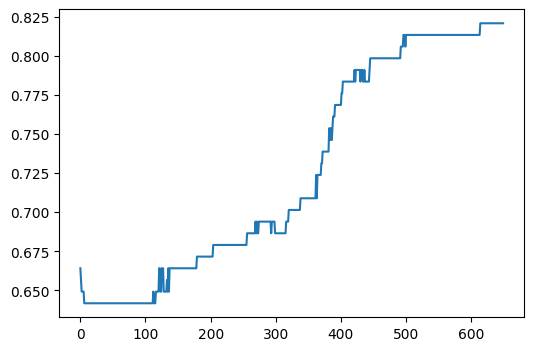

In [ ]:
plt.plot(val_acc_hist)

悪くない。<br>
Not bad.

In [ ]:
print(test_X.shape)
test_loader = DataLoader(test_X, batch_size=418)

torch.Size([418, 92])


In [ ]:
with torch.no_grad():

    for test_batch in test_loader:
        model.eval()
        pid = test_batch[:, 0].unsqueeze(1)
        X = test_batch[:, 1:]
        pred = model(X)
        pred = torch.round(F.sigmoid(pred))

print("done")

done


In [ ]:
print(pid.shape, pred.shape)

torch.Size([418, 1]) torch.Size([418, 1])


In [ ]:
pid = pid.to(torch.int).numpy()
pred = pred.to(torch.int).numpy()

In [ ]:
data = {"PassengerId": pid.squeeze(), "Survived": pred.squeeze()}
submit = pd.DataFrame(data)

In [ ]:
submit.to_csv('submission.csv', index=False)

<h3>雑感</h3>
<p>本来、サンプル数891しかない標本ではディープラーニングは最適な選択肢ではなく、他の機械学習手法を使用した方が賢明なのだろうとは思う。正直、最初は全く上手くいかず、このデータ数でディープラーニングは無理かと挫折しかけた。</p>
<p>ただ、個人的に AI とディープラーニングへの関心から学習を始めた経緯から、いくらか工夫してでもディープラーニングによる予測の実装にこだわってみた。</p>
<p>具体的な工夫としては、ドロップ率 0.9 のドロップアウトの使用である。一般にドロップアウトは、モデルの過学習を防ぎ、未知の値に対してより堅牢なモデルにする効果があると言われており、実際に使用されるときのドロップ率は 0.5 くらいが多いらしい。個人的にはこれはサンプル数が少ない標本におけるサンプル数の水増しの効果があるのではないかと考えた。</p>
<p>今回、私が構築したモデルでは 91 次元の入力ベクトルを取るが、Age のデータを 0 ～ 80 までの 81 次元のワンホットベクトルとして表現しており、更に Pclass と Embarked もそれぞれ 3 次元のワンホットベクトルという、とてもスパース(疎)な入力ベクトルなっている。このようなスパースな学習データでモデルを学習させるには大量のサンプルが欲しい所であるが、今回のケースでそれは不可能だ。</p>
<p>そこで今回のモデルの入力が、91 次元ベクトル中 Pclass、Embarked、Age 、それぞれ 3次元、3次元、81次元のワンホットベクトルで表現された極めてスパースな入力になっているのを逆手に取った。今回のモデルに使用するようなスパースなベクトルでは、重要な特徴は僅かであり、その重要な特徴が来たときだけ敏感にシナプスが強化されればよい（Age 0 歳や、Pclass 1 など）。</p>
<p>どうせスパースな入力なら、いっそ全ての層でランダムなデータゼロ落ちを極端な割合で行うことにより、大量のエポック数を回してもモデルからは本来 757 パターンしかない学習データがさも全く違う新しいデータが大量に流れてくるように見えるのではないか、かつ重要な特徴にだけ敏感に反応するようになるのではないか、という素人ながらの思い付きである。そもそも入力が大変にスパースであり、重要な特徴が僅かな入力ベクトルを採用した今回のモデル構築で、これは上手くいきそうに思えた。</p>
<p>実際、これはなかなか上手くいき、891 の学習データを更に学習用と検証用に 0.85:0.15 に分けた、たった 757 のサンプルから Kaggle のパブリックスコア 0.77751 のディープラーニング予測モデルを構築できた。(これはチュートリアルで実装するランダムフォレストモデルより、ほんのちょっとだけ良い)</p>
<p>データサイエンス独学の素人の Kaggle 初挑戦としては、まぁこんなものだろう。</p>